In [ ]:
import gym
import hiive.mdptoolbox, hiive.mdptoolbox.example, hiive.mdptoolbox.mdp
import hiive.mdptoolbox as mdptoolbox
import hiive.visualization
import numpy as np
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(42) 
# set this so that in QL taking random actions based upon the value of epsilon, 
# you're generating random numbers consistently to compare against epsilon

N_EPISODES = 1000

In [2]:
env_state = []
def setup_game():
    # 8x8
    # from gym implementation
    MAPS = {
        '4x4': ['SFFH',
                'FHFF',
                'FFFF',
                'HFFG'
        ],
        '8x8': ["SFFFFFFF",
                "FFFFFFFF",
                "FFFHFFFF",
                "FFFFFHFF",
                "FFFHFFFF",
                "FHHFFFHF",
                "FHFFHFHF",
                "FFFHFFFG"],
        '12x12': ['SFFFFHHFFHFF', 'FFFFFFFFFFFF', 'HFFFFFFFHHFF', 'FFFFFFFFHFFF', 
                  'FFFFFFHHFFFH', 'HFFFFFFFFFFF', 'FFFFHFHFHHHH', 'FFFFFFFHFFFH', 
                  'FFFFFFFHHHFF', 'FFFFFFHFFFFH', 'FFHFHFFFFFFF', 'FFFHFFFFHFFG']
            }

    # order from ai gym for my sanity
    actions = ['LEFT', 'DOWN', 'RIGHT', 'UP']

    # Environment
    # from https://gym.openai.com/docs/
    # https://www.kaggle.com/angps95/intro-to-reinforcement-learning-with-openai-gym
    curr_map = MAPS['8x8']
    #curr_map = MAPS['12x12']
    env = gym.make('FrozenLake-v0', desc=curr_map)

    # check environment
    env.render()

    # Set up transition and rewards matrices
    env.reset() # just to be sure we're at the start state in the grid world
    n_size = env.nS
    print("# States: " + str(n_size))
    n_action = env.nA
    print("# Actions: " + str(n_action))

    # for visualization later
    for r in curr_map:
        env_state.append(list(r))

    # from MDP docs, use numpy array that has the shape (A, S, S) for reward and trans
    trans = np.zeros([n_action, n_size, n_size])
    #reward = np.zeros((n_action, n_size, n_size))
    reward = np.zeros([n_size, n_action])

    # P is the transition matrix
    for s, s_info in env.P.items():
        for a, a_info in s_info.items():
            for i, info in enumerate(a_info):
                p = info[0]
                s_prime = info[1]
                r = info[2]
                reward[s, a] = r
                trans[a, s, s_prime] += p
            trans[a, s, :] /= np.sum(trans[a, s, :])

    # confirm that we have a valid reward and transition matrix
    mdptoolbox.util.check(trans, reward)
    return env, trans, reward



SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
# States: 64
# Actions: 4


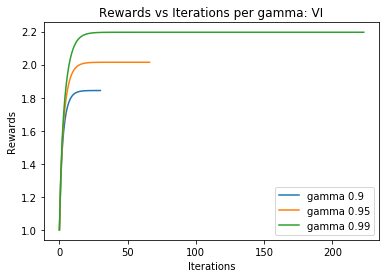

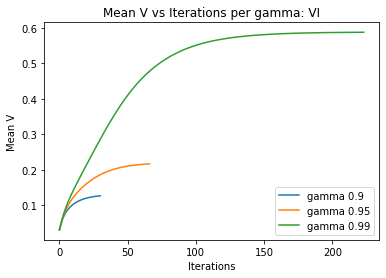

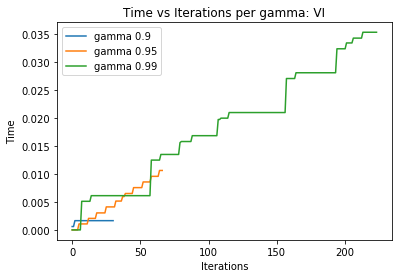

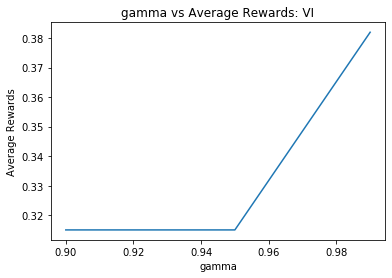

In [3]:
# Value Iteration
env, trans_m, reward_m = setup_game()
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
#epsilon = [.01, .001, .0001, .00001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
max_moves = 1000
avg_episode_rewards = []
for g in gamma:
    vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.01 ,gamma=g)
    vi.run()
    episode_results = []
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = vi.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward
            if done:
                break
            if moves > max_moves:
                break       
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in vi.run_stats]
    plt.figure(1)
    plt.plot(range(0, vi.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: VI")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/Rewards_vs_Iterations_vi_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in vi.run_stats]
    plt.figure(2)
    plt.plot(range(0, vi.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: VI")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/MeanV_vs_Iterations_vi_gamma.png')
    
    time_stats = [stat['Time'] for stat in vi.run_stats]
    plt.figure(3)
    plt.plot(range(0, vi.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: VI")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/vi_frozen/Time_vs_Iterations_vi_gamma.png')
    
    
plt.figure(4)
plt.plot(gamma, avg_episode_rewards)
plt.title("gamma vs Average Rewards: VI")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/vi_frozen/Average_Rewards_vs_Gamma_vi.png')
    
    

iterations:224
Time: 0.0298614501953125
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0)
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 1 1 1 0]]


c:\users\spcbe\miniconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


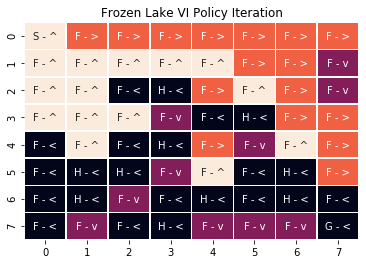

In [18]:
# Show Optimal policy
vi = mdptoolbox.mdp.ValueIteration(trans_m, reward_m, epsilon=.01 ,gamma=.99)
vi.run()
print('iterations:' + str(vi.iter))
print('Time: ' + str(vi.time))
print('Policy: ' + str(vi.policy))
visualize_policy(vi.policy, rl_type='VI')


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
# States: 64
# Actions: 4


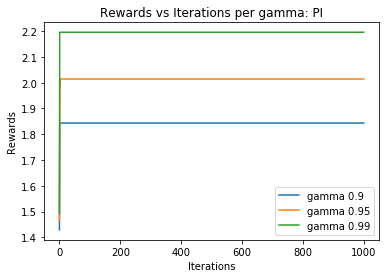

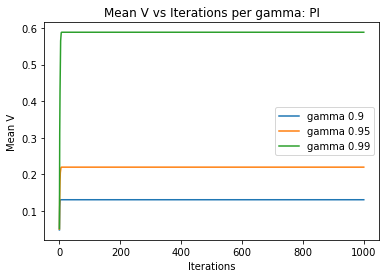

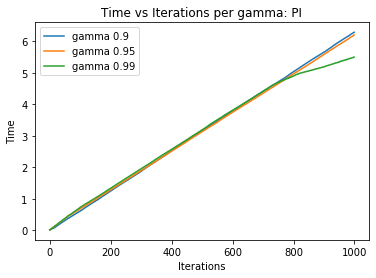

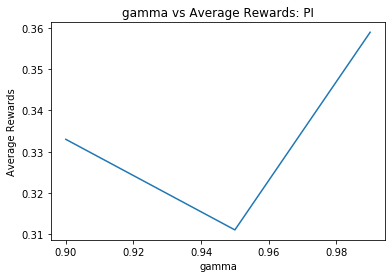

In [21]:
# Policy Iteration
env, trans_m, reward_m = setup_game()
# hparams tuning
# gamma
gamma = [.9, .95, .99]

#stopping factor
#epsilon = [.01, .001, .0001, .00001]


# test each policy by playing the game, step x step, taking the optimal action in the policy
max_moves = 1000
avg_episode_rewards = []
for g in gamma:
    pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m, gamma=g)
    pi.run()
    episode_results = []
    episode_rewards = []
    # play game
    for i_episode in range(N_EPISODES):
        state = env.reset() # reset state to s0.
        moves = 0
        done = False
        total_rewards = 0
        while not done:
            action = pi.policy[state]
            state, reward, done, info = env.step(action)
            moves += 1
            total_rewards += reward
            if done:
                break
            if moves > max_moves:
                break       
        env.close()
        episode_rewards.append(total_rewards)
    ave_rewards = sum(episode_rewards) / N_EPISODES
    avg_episode_rewards.append(ave_rewards)
        
    
    reward_stats = [stat['Reward'] for stat in pi.run_stats]
    plt.figure(1)
    plt.plot(range(0, pi.iter), reward_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Rewards vs Iterations per gamma: PI")
    plt.ylabel("Rewards")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Rewards_vs_Iterations_pi_gamma.png')
    
    
    meanv_stats = [stat['Mean V'] for stat in pi.run_stats]
    plt.figure(2)
    plt.plot(range(0, pi.iter), meanv_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Mean V vs Iterations per gamma: PI")
    plt.ylabel("Mean V")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/MeanV_vs_Iterations_pi_gamma.png')
    
    time_stats = [stat['Time'] for stat in pi.run_stats]
    plt.figure(3)
    plt.plot(range(0, pi.iter), time_stats, label="gamma " + str(g))
    plt.legend()
    plt.title("Time vs Iterations per gamma: PI")
    plt.ylabel("Time")
    plt.xlabel("Iterations")
    plt.savefig('../images/pi_frozen/Time_vs_Iterations_pi_gamma.png')
    
    
plt.figure(4)
plt.plot(gamma, avg_episode_rewards)
plt.title("gamma vs Average Rewards: PI")
plt.xlabel("gamma")
plt.ylabel("Average Rewards")
plt.savefig('../images/pi_frozen/Average_Rewards_vs_Gamma_pi.png')
    

In [25]:
# Show Optimal policy
pi = mdptoolbox.mdp.PolicyIteration(trans_m, reward_m,gamma=.99)
pi.run()
print('iterations:' + str(pi.iter))
print('Time: ' + str(pi.time))
print('Policy: ' + str(pi.policy))
# Did they converge to the same policy?
print(vi.policy == pi.policy)
visualize_policy(pi.policy, rl_type='PI')

iterations:1000
Time: 6.048665523529053
Policy: (3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 1, 3, 3, 0, 0, 2, 3, 2, 1, 3, 3, 3, 1, 0, 0, 2, 2, 0, 3, 0, 0, 2, 1, 3, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 1, 3, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0)
False
[[3 2 2 2 2 2 2 2]
 [3 3 3 3 3 2 2 1]
 [3 3 0 0 2 3 2 1]
 [3 3 3 1 0 0 2 2]
 [0 3 0 0 2 1 3 2]
 [0 0 0 1 3 0 0 2]
 [0 0 1 3 0 0 0 0]
 [0 1 0 0 2 1 1 0]]


ValueError: operands could not be broadcast together with shapes (64,) (256,) 

In [ ]:
# QL

# hparams
# learning rate - fewer so ql finishes
discount = [.7, .8, .9]
# number of iterations...QL usually needs a lot to solve
iterations = [100000, 1000000, 2000000]

best_hparams = {'d': -1, 'won': 0.0, 'moves': 0, 'ql_iters': 0, 
                'time': 0.0, 'policy': None, 'value': None, 'q': None}
win_stats_by_episode = []

for d in discount:
    print('Discount ' + str(d))
    for it in iterations:
        print('Number Iters ' + str(it))
        # using the hiive version of QLearning will let me tune more
        ql = mdptoolbox.mdp.QLearning(trans, reward, gamma=d, n_iter=it)
        ql.setVerbose()
        ql.run()
        # returns moves, reward for each episode
        results = play_game(env, ql.policy)
        
        # only tracking won games in result
        if len(results) > 0:

            percent_won = len(results) / N_EPISODES
            moves_taken = math.floor(sum([r['moves'] for r in results]) / N_EPISODES)

            # overall episode stats
            win_stats_by_episode.append({'won': percent_won,'moves': moves_taken, 'iters': it,
                                         'time': ql.time,'policy': ql.policy, 'value': ql.V,'d': d,
                                        'q': ql.Q })
            if percent_won > best_hparams['won']:
                best_hparams['d'] = d
                best_hparams['won'] = percent_won
                best_hparams['moves'] = moves_taken
                best_hparams['ql_iters'] = it
                best_hparams['time'] = ql.time
                best_hparams['policy'] = ql.policy
                best_hparams['value'] = ql.V
                best_hparams['q'] = ql.Q

print("***BEST***")
print(best_hparams)
visualize_policy(win_stats_by_episode, rl_type='QL')
visualize_stats(win_stats_by_episode, rl_type='QL')
            
# Play again with the best?
best_results = play_game(env, best_hparams['policy'])
#visualize_policy(best_results, 'Frozen QL Policy-Best', True, 'QL')

#win_lose = Counter([r['reward'] for r in best_results])
#print((win_lose[1] / N_EPISODES) * 100)
print((len(best_results) / N_EPISODES) * 100)

#V (tuple) – value function
#policy (tuple) – optimal policy
#iter (int) – number of done iterations
#time (float) – used CPU time

In [ ]:
# did it converge to the same policy?
print(vi.policy == ql.policy)
print(pi.policy == ql.policy)

In [17]:
def visualize_policy(policy, rl_type=''):    
    action_taken = {0: '<', 1: 'v', 2: '>', 3: '^'}
    
    dim = int(np.sqrt(env.nS))
    state_arr = (dim, dim)
    # reshape tuple as array
    policy_arr = np.reshape(policy, state_arr)
    print(policy_arr)
    policy_labels = np.vectorize(action_taken.get)(policy)
    e_state = [item for sublist in env_state for item in sublist]
    for a in policy:
        # add the state labels
        temp = []
        for x, y in np.nditer([policy_labels, e_state]):
            x = ' - '.join([str(y), str(x)])
            temp.append(x)
    policy_labels = np.reshape(temp, state_arr)
    
    plot = sns.heatmap(policy_arr, annot=policy_labels, fmt='', linewidth=.6, cbar=False)
    title = f'Frozen Lake {rl_type} Policy Iteration' 
    plot.title.set_text(title)
    fig = plot.get_figure()
    fig.savefig('../images/' + rl_type.lower() + '_frozen/policy_frozen_' + rl_type + '_.png')
    fig.show()
    #fig.clf()
        

In [ ]:
# Taken as is from https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


In [ ]:
# Used to initially generate constant maps 
m = generate_random_map(size=30)
print(m)